In [1]:
'''
Cumulative test of RouteMap, BusModel, and TripDynamics.
'''

'\nCumulative test of RouteMap, BusModel, and TripDynamics.\n'

In [2]:
# General Imports
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
# Package Imports
import RouteMap as rm
import BusModel as bm
import TripDynamics as td
import Helper_Methods as hm

In [4]:
# Import the relevant area data:
# All Transit Stops:
stops_path = "./Data/Transit_Stops/Transit_Stops_for_King_County_Metro__transitstop_point.shp"
stops = gpd.read_file(stops_path)

# All signal lights:
signals_path = "./Data/Signals/KCM_Signals.shp"
signals = gpd.read_file(signals_path)

# All Streets:
seattle_streets_data ="./Data/Seattle_Streets/KCM_Streets.shp"
seattle_streets = gpd.read_file(seattle_streets_data)

In [5]:
# make a duplicate of the stops
all_stops = stops.copy()

# make a series of the signal geometry
all_signals = signals['geometry'].reset_index(drop=True)

# get the speed limits of all streets in the dataset
limits = seattle_streets[['geometry', 'SPEED_LIM']]

In [6]:
# set the route number, number of samples of points
# and time period of interest
route = 101
concat_val = 6
period = 'AM'

# Import the route data
route_path = "./Data/Routes/Individual_Routes/rt{}_pts.shp".format(route)
route_raw = gpd.read_file(route_path)

# filter to the resolution of the concat value
route_concat = route_raw[::concat_val]
route_concat = route_concat.reset_index(drop=True)

# get a series of the geometry and elevation from the data
route_geometry = route_concat['geometry']
route_elevation = route_concat['Z']

# using the helper method get_stops, find all stops the route intersects with.
route_stops = hm.get_stops(all_stops, str(route))['geometry'].reset_index(drop=True)

In [ ]:
# Generate a RouteMap with the RouteMap module, passing 
# the route geometry, elevation, limits, route_stops, 
# signals.
route_test_map = rm.RouteMap(route_geometry,
                             route_elevation,
                             limits,
                             route_stops,
                             all_signals,
                             debug = True)


#save the route_map as a csv for future, faster, use. 
route_test_map.get_gdf().to_csv('./Data/SAVED_ROUTEMAPS/route_map_{}.csv'.format(route))

In [7]:
# Load the RouteMap from the CSV
# First, generate a routemap from the geometry and elevation
route_test_map = rm.RouteMap(route_geometry, route_elevation)

# Add in the details from the saved CSV
route_test_map = route_test_map.load_from_gdf('./Data/SAVED_ROUTEMAPS/route_map_{}.csv'.format(route))

In [8]:
# Use in-built methods in RouteMap to get a smoothed elevation
# as a pandas series
smoothed_test_elevation = route_test_map.smooth_elevation()

# set the smoothed elevation as the route_test_map's elevation
smoothed_test_map = route_test_map.set_elevation(smoothed_test_elevation)


# convert distances using elevation to true distances traveled:
p_dist_elev = route_test_map.calc_travel_distances()
route_test_map = route_test_map.set_point_distances(p_dist_elev)

<Axes: >

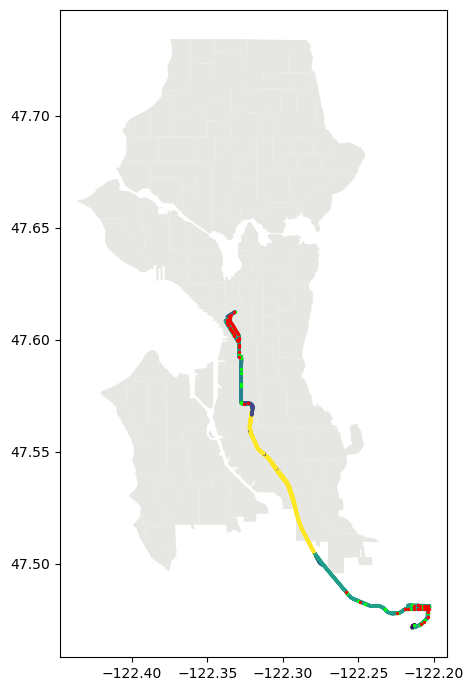

In [9]:
# Display a map of the route overlayed over area data:
# Import area map:
seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")

# filter out all 'water' zones in the data for clarity
seattle = seattle[(seattle['WATER'] != 1)]

# set up a figure:
fig, ax = plt.subplots(1, figsize = (5,10))

# Plot the map of the area:
seattle.plot(color="#E6E6E3", ax=ax, zorder = 0)

# get the geodtaframe of the route_map
smooth_route_gdf = smoothed_test_map.get_gdf()

# plot the route by speed limit individually
smooth_route_gdf.plot(column='speed_limit[km/s]',
                      markersize=2,
                      ax=ax,
                      alpha=1,
                      zorder=10)


# plot the stops and signals
smooth_route_gdf[smooth_route_gdf['is_stop'] == True].plot(color='lime',
                                                           markersize=2,
                                                           ax=ax,
                                                           zorder=15)
smooth_route_gdf[smooth_route_gdf['is_signal'] == True].plot(color='red',
                                                             markersize=2,
                                                             ax=ax,
                                                             zorder=20)
                                                             


In [10]:
# Creating a bus model:
# Import an acceleration profile
acc_prof_path = "./Data/Accel_Prof/acceleration.csv"
raw_acc_prof = pd.read_csv(acc_prof_path, names=['time[s]', 'accel.[g]'])

# Make a duplicate to alter
a_prof = raw_acc_prof.copy()

# Convert g's to m/s^2 and then drop g's
a_prof['accel.[m/s^2]'] = a_prof['accel.[g]'] * 9.81
a_prof = a_prof.drop(columns = ['accel.[g]'])

# Create a default bus with the acceleration profile from above,
# otherwise using the default parameters
default_bus = bm.BusModel(a_prof)

In [11]:
# Creating a trip:
# Load the ridership data
ridership_path = "./Data/Trip_Data/Zon183Unsum.csv"
kcm_ridership = pd.read_csv(ridership_path)

# filter the ridership to the selected period and route
trip_ridership = kcm_ridership[(kcm_ridership['Route']==route) & (kcm_ridership['Period']==period)]

# sort the route_ridership so the stops are in proper order
sorted_riders = trip_ridership.sort_values(by=['InOut','Trip_ID', 'STOP_SEQ', 'STOP_ID'])
sorted_riders = sorted_riders[['InOut','STOP_SEQ', 'STOP_ID', 'AveOn', 'AveOff', 'AveLd']]
sorted_riders = sorted_riders.drop_duplicates(subset=['InOut','STOP_SEQ'], keep='first')
sorted_riders = sorted_riders.drop_duplicates(subset='STOP_ID', keep='first')
sorted_riders = sorted_riders.reset_index(drop = True)
sorted_riders['Index'] = sorted_riders.index

# get the mean ridership change at each stop
sorted_riders_diff = sorted_riders['AveOn'] - sorted_riders['AveOff']

#Export the rider difference to a csv for ease of editing and access
#sorted_riders_diff.to_csv('rider_diff_{}.csv'.format(route))
#sorted_riders_diff = pd.read_csv('./Data/Testing_materials/test_diff_22.csv')['0']
sorted_riders_diff = sorted_riders_diff[:len(smooth_route_gdf[smooth_route_gdf['is_stop'] == True])]

In [128]:
import pandas as pd
import numpy as np

class BusModel:
    def __init__(self,
                 acceleration_profile, # two column dataframe containing time(s), accel(m/s^2)
                 raw_mass = 13041, # kilograms, unknown bus model
                 bus_width = 2.6, # meters, unknown bus model
                 bus_height = 3.3, # meters, unknown bus model
                 drag_coeff = 0.6, # default from unknown bus model
                 wheel_rad = 0.5, # meters, unknown bus model
                 factor = 1.1, # intertial factor.
                 fric_coeff = .01, # default from erica's
                 motor_eff = .916, # unknown source
                 invert_eff = .971, # unknown source
                 max_power = 160, # kW, output motor
                 regen = .6, # unknown source
                 eff_aux = .89, # unknown source, Auxulliary system efficiency?
                 aux_load = 0, # W, no default system load
                 a_braking = -1.5, #m/s^2 # https://www.apta.com/wp-content/uploads/APTA-BTS-BC-RP-001-05_Rev1.pdf <-- Possible source, handbrake road minimum is ~1.5
                 final_a = .4, # m/s^2, defualt acceleration after profile finishes
                 max_velocity = 26.8224, # m/s, = 60 mph
                 maintain_acceleration = False, # boolean for if bus should maintain the last a in 
                                                # profile or use final_a for extrapolating new vals
                 num_starting_passengers = 0,
                 pass_ave_mass = 80, #kg
                
                 ):
        # raw bus characteristics -- Not all of these are used, but may be useful for the future
        self._empty_mass = raw_mass
        self._bus_width = bus_width
        self._bus_height = bus_height
        self._bus_front_area = self._bus_width * self._bus_height
        self._drag_coeff = drag_coeff
        self._wheel_rad = wheel_rad
        self._i_factor = factor
        self._fric_coeff = fric_coeff
        self._motor_eff = motor_eff
        self._invert_eff = invert_eff
        self._max_power = max_power
        self._regen = regen
        self._eff_aux = eff_aux
        self._aux_load = aux_load
        
        # driving model characteristics
        self._a_braking = a_braking
        self._final_a = final_a
        self._final_a_boolean = maintain_acceleration
        self._max_v = max_velocity
        self._accel_profile_df = self.interpret_accel_prof(acceleration_profile)
        
        # variables based on position in route
        self._passengers = num_starting_passengers
        self._mass_p_pass = pass_ave_mass
        self._current_velocity = 0
        self._current_accel = 0
        self._distance_traveled = 0
        self._bus_status = "Stopped"
        self._current_mass = self._empty_mass + self._passengers * self._mass_p_pass
        
        
    def interpret_accel_prof(self, accel_prof):
        """
        interpret_accel_prof is used to format the acceleration
        profile so as to have velocity and distance traveled.
        
        Parameters:
        accel_prof: dataframe of time and acceleration values,
                    in seconds and m/s^2.
        
        Returns: 
        dataframe of time, acceleration, velocity, and distance
        in seconds and meters units.
        """
        # Generate a copy of the profile
        acc_prof = accel_prof.copy()
        
        # Get the changes in time
        acc_prof['dt'] = acc_prof['time[s]'].diff()
        
        # use mean_integral to get the velocity data
        acc_prof['vel.[m/s]'] = self.mean_integral(acc_prof['dt'], acc_prof['accel.[m/s^2]'])
        
        # use mean_integral to get the distance data
        acc_prof['dist.[m]'] = self.mean_integral(acc_prof['dt'], acc_prof['vel.[m/s]'])
        
        while (not (acc_prof['vel.[m/s]'].iloc[-1] >= self._max_v)):
            
            # Generate a new row dictionary from the columns
            new_row = dict.fromkeys(list(acc_prof.columns))
            
            # set the step time to be 1 second
            d_t = 1
            
            # calculate the next time point using the previous and dt
            next_time = acc_prof['time[s]'].iloc[-1] + d_t 
            
            # default to using the _final_a acceleration
            next_accel = self._final_a
            
            # if the parameters say to maintain acceleration,
            if self._final_a_boolean:
                # Keep the last acceleration
                next_accel = acc_prof['accel.[m/s^2]'].iloc[-1]
            
            # calculate the next velocity
            next_v = acc_prof['vel.[m/s]'].iloc[-1] + d_t*next_accel
            
            # calculate the next distance
            next_d = acc_prof['dist.[m]'].iloc[-1] + d_t * (next_v + acc_prof['vel.[m/s]'].iloc[-1]) / 2
            
            # generate the list of data
            data = [next_time, next_accel, d_t, next_v, next_d]
            
            # put the data into the dictionary
            for i in range(len(data)): new_row[list(new_row.keys())[i]] = data[i]
            
            # Append the new row on to the profile dataframe
            acc_prof.loc[len(acc_prof)] = new_row
            
        # drop the dt column
        #acc_prof = acc_prof.drop(columns = ['dt'])
        
        # return the acceleration profile dataframe
        return acc_prof
    
    
    def mean_integral(self, time_changes, value_series):
        """
        mean_integral takes in a series of dt (s) values, and
        a corresponding series of other values to be integrated
        with respect to time, and provides the result as a
        cumulative summing series. 

        Parameters:
        time_changes: a pandas series of dT values in units of seconds
        value_series: a pandas series of d[value] that has relation to time.

        Returns: 
        a pandas series of the integrated values.
        """
        int_prof = pd.DataFrame()
        int_prof['mean_val_btw'] = value_series.rolling(window=2).mean()
        int_prof['d[value]'] = int_prof['mean_val_btw'] * time_changes
        int_prof['integrated'] = int_prof['d[value]'].cumsum()

        return int_prof['integrated'].fillna(0)
    
    
    def get_accel_profile(self):
        return self._accel_profile_df
    
    
    def velocity(self):
        return self._current_velocity
    
    
    def set_v(self, v):
        self._current_velocity = v
    
    
    def max_velocity(self):
        return self._max_v
    
    
    def accelerate(self, dist):
        '''
        accelerate() is a method of calculating the effect of 
        acceleration has on the bus through the acceleration profile.
        Note: This is currently unused in the Trip class, as it is
        not as accurate to the true experience as accelerate_v2().
        
        Parameters:
        dist: distance, in meters, the bus accelerates
        
        Returns:
        power_used: a value, in watts, of power used to accelerate as a float.
        '''
        # Get current velocity
        prev_v = self._current_velocity
        
        # get a copy of the acceleration profile
        prof = self.get_accel_profile().copy()
        
        prof['force[N]']=self._current_mass*prof['accel.[m/s^2]']
        prof['force[N]']=prof['force[N]'].cumsum()
        
        prof['energy[J]'] = prof['force[N]']*(prof['dist.[m]'].shift(-1))
        prof['power[W]'] = prof['energy[J]']*(prof['dt'].shift(-1))
        
        # get the closest velocity in the acceleration profile
        closest_v = prof.iloc[(prof['vel.[m/s]'] - prev_v).abs().argsort()[:1]]
        
        
        # get the index of the closest velocity in the profile
        starting_index = (list(closest_v.index))[0]
        
        # generate an acceleration distance column based on the starting point of closest v
        prof['accel_dist'] = prof['dist.[m]'] - int(closest_v['dist.[m]']) - dist
        
        # zero the velocity to the current velocity
        zeroed_v = prof.iloc[(prof['accel_dist'] - 0).abs().argsort()[:1]]
        
        # get the final index of the zeroed v
        final_index = (list(zeroed_v.index))[0]
        
        # set the current velocity to the final index of the acceleration
        self._current_velocity = prof['vel.[m/s]'][final_index]
        force_applied = prof['force[N]'][final_index] - prof['force[N]'][starting_index] 
        time_taken = prof['time[s]'][final_index] - prof['time[s]'][starting_index] 
        
        # set the distance traveled to the sum of the previous value and the
        # travel distance
        self._distance_traveled = dist + self._distance_traveled
        
        # change bus status
        self._bus_status = 'moving'
        
        # get the raw acceleration energy
        accelerate_energy_raw = force_applied*dist
        
        # Calculate the power used in watts
        power_used = accelerate_energy_raw/time_taken # Watts
        
        # Return the power used
        return power_used
    
    
    def accelerate_v2(self, dist):
        '''
        accelerate_v2() takes in a distance value, and determines the power
        and time change the bus requires to accelerate that distance.
        
        Parameters:
        dist: distance, in meters (float), the bus accelerates.
        
        Returns:
        a touple containing the power [W] used and the elapsed time [s]. 
        '''
        # get the current velocity of the bus.
        prev_v = self._current_velocity
        
        # get a copy of the acceleration profile.
        prof = self.get_accel_profile().copy()

        # set the previous velocity as the zero index in velocity
        prof.at[0, 'vel.[m/s]'] = prev_v 
        
        # Set up columns for force, energy, power, and distance change
        prof['force[N]']=self._current_mass*prof['accel.[m/s^2]']
        prof['energy[J]'] = 0
        prof['power[W]'] = 0
        prof['dx[m]'] = 0
        
        # set up variables for accelerated distance and index
        accelerated_dist = 0
        i=0
        
        # Loop through the acceleration profile so long as the bus has not yet traveled the
        # target distance and so long as the power does not exceed the maximum output of the
        # motors. 
        while ((dist > accelerated_dist) & (prof['power[W]'].iloc[i] < self._max_power*1000)):
            # Set v0 to the velocity at index
            v0 = prof['vel.[m/s]'][i]
            
            # get current acceleration
            a = prof['accel.[m/s^2]'][i]
            
            # get the change in time
            dt = prof['dt'][i+1]
            
            # using kinematics equations, calculate change in distance,
            # and the final velocity
            dx = v0*dt + (1/2)*a*(dt**2)
            vf = np.sqrt(v0**2 + 2*a*dx)
            
            # Set the next variables to the newly calculated ones.
            prof.at[i+1, 'vel.[m/s]'] = vf
            prof.at[i+1, 'dx[m]'] = dx
            prof.at[i+1, 'energy[J]'] = prof['force[N]'][i+1]*dx
            prof.at[i+1, 'power[W]']= prof['energy[J]'].iloc[i+1]/dt
            accelerated_dist += dx
            
            # Index by one.
            i+=1
        # Get the final velocity value and elapsed time
        final_v = prof['vel.[m/s]'].iloc[i]
        dt = prof['time[s]'].iloc[i]
        
        # set the current values to the bus's storage variables
        self._current_velocity = final_v
        self.distance_traveled = dist + self._distance_traveled
        self._bus_status = 'moving'
        
        # Calculate the mean power used in watts
        power_used = prof['power[W]'].cumsum()[i]/i # Watts
        
        # return the power used and the elapsed time
        return power_used, dt
        
           
    def brake(self, dist, braking_factor):
        '''
        brake() takes in a distance and braking factor,
        and determines the power and elapsed time for the bus to
        experience those conditions.
        '''
        
        # Get the current velocity and braking acceleration, 
        # using the factor to help determine how intense the braking is.
        v0 = self._current_velocity
        braking_acc = self._a_braking*braking_factor
        
        # Use the kinematics equations to calculate the final velocity
        v2 = v0**2
        dv2 = braking_acc*dist*2
        final_v = 0
        if (v2>np.abs(dv2)):
            #print(v2 + dv2)
            final_v = np.sqrt(v0**2 + 2*braking_acc*dist)
        self._current_velocity = final_v
        
        # get the braking force and energy, and set the current acceleration
        # to the braking acceleration. 
        braking_force = braking_acc*self._current_mass
        braking_energy_raw = braking_force*dist
        self._current_accel = braking_acc
        
        # Calculate the power of the braking and the change in distance
        power_calc = braking_energy_raw/((final_v - v0)/braking_acc)
        dt = dist / (abs(final_v - v0)/2)
        
        # return the power and elapsed time.
        return power_calc, dt
    
    
    def maintain(self, dist, ext_acc):
        '''
        maintain() takes in distance traveled and the external 
        accelerational forces, and calculates the power needed to
        maintain the current velocity and the elapsed time.
        
        Parameters:
        dist: distance of travel in meters as a float.
        ext_acc: external accelerative force the bus is currently experiencing.
        
        Returns:
        a touple containing the power [W] used and the elapsed time [s]. 
        '''
        
        # The current external acceleration from what was passed
        current_ext_acc = ext_acc

        # Get current bus mass
        cur_mass = self._current_mass
        
        # get the external force from the mass and acceleration
        ext_force = cur_mass * current_ext_acc
        
        # The engine force should compensate to balance
        # the difference between the external forces
        eng_force = -(ext_force)
        
        # get the energy to maintain the force for the distance
        maintain_energy_raw = eng_force*dist
      
        dt = dist/self._current_velocity
        
        power_calc = maintain_energy_raw/dt
        
        # return the energy value
        return power_calc, dt
    
    
    def get_braking_distance(self, velocity, braking_factor, ext_acc):
        '''
        get_braking_distance() takes in a velocity and the current external accelerations,
        and provides a calculation as to how far the bus would have to brake to reach a velocity of zero.
        
        Parameters:
        velocity: velocity, in m/s, the bus is travelling at
        ext_acc: the external accelerative force in m/s^2 the bus is experiencing.
        
        Returns:
        a distance, in meters, of how far the bus would have to brake to reach a velocity of zero.
        '''
        
        
        wind_accel = self.get_aerodynamic_drag(velocity, 0, 1.2)
        
        # Combine to get the net acceleration on the bus
        net_accel = wind_accel - ext_acc
        a_bus = net_accel + self._a_braking*braking_factor*self._i_factor
        
        # Using the kinematics equation vf^2 = vi^2 + 2a(dX) to get
        # braking distance
        return round((-velocity**2 / (2*(a_bus))), 5) # Convert to meters

    
    def get_aerodynamic_drag(self, bus_speed, wind_speed, air_density):
        '''
        get_aerodynamic_drag takes in wind speed and air density, and returns
        the acceleration, in m/s^2, they provide.
        
        Parameters:
        wind_speed: velocity, in m/s, of the wind.
        air_density: density, in kg/m^3, of the air.
        
        Returns:
        aerodynamic acceleration, in m/s^2.
        '''
        # Using the drag coefficient, bus frontal area, and passed parameters, calculate the acceleration of air due to drag
        air_drag = (self._drag_coeff * self._bus_front_area * (air_density/2) * (bus_speed - wind_speed)**2)/self._current_mass
        
        # Return said value.
        return air_drag # acceleration of air drag
    
    
    def get_inertial_acceleration(self):
        '''
        get_inertial_acceleration calculates the current acceleration of intertia the bus is undergoing.
        
        Parameters:
        N/A
        
        Returns:
        inertial acceleration of the bus, in Newtons.
        
        '''
        
        # Use the intertial factor, current mass, and current acceleration,
        # to get inertial acceleration.
        inertia = (self._i_factor * self._current_mass * self._current_accel) / self._current_mass
        return inertia # acceleration of inertia
    
    
    def update_riders(self, val, cat='change'):
        '''
        update riders takes in a value of how many riders get on (positive),
        or disembark (negative), and affects the bus mass and passenger count of the bus.
        
        Parameters:
        val: change in passengers as a float.
        cat: string, either 'change' or 'set', depending on if the number of passengers
             is being changed, or set. Default is 'change'.
        '''
        # Update passenger number, sum should never be < 0
        if (cat=='change'):
            self._passengers = self._passengers + val
        elif (cat == 'set'):
            self._passengers = val
        
        # Update total mass
        self._current_mass = self._empty_mass + self._passengers * self._mass_p_pass
        return None
    
    
    # Getter methods
    def update_mass(self, val):
        self._current_mass = val
        return None
    
    def get_n_riders(self):
        return self._passengers
    
    def get_mass(self):
        return self._current_mass
    
    def get_acceleration(self):
        return self._current_accel
    
    def get_fric_coeff(self):
        return self._fric_coeff

    def get_b_accel(self):
        return self._a_braking
    
    def get_motor_eff(self):
        return self._motor_eff
    
    def get_invert_eff(self):
        return self._invert_eff
    
    def get_auxill_efficiency(self):
        return self._eff_aux
    
    def get_aux_load(self):
        return self._aux_load
    
    def get_regen_eff(self):
        return self._regen
    
    def accelerate_v3(self, dist, ext_acc):
        
        # Get acceleration profile
        prof = self.get_accel_profile().copy()
        
        # get current mass and velocity
        mass = self._current_mass
        vel = self._current_velocity
        
        # set a variable for the route acceleration
        route_accel = ext_acc
        
        # Calculate inertial acceleration
        inertial_accel = prof['accel.[m/s^2]']*self._i_factor
        inertial_accel = inertial_accel.shift(1)
        
        # get the acceleration of drag, with wind speed of 0 and air density of
        # 1.2 kg/m^3, to be adjustible later
        wind_accel = prof.apply(lambda x: self.get_aerodynamic_drag(x['vel.[m/s]'], 0, 1.2), axis=1)
        
        # calculate the true acceleration needed to reach the target acceleration
        net_acc_for_target = prof['accel.[m/s^2]'] - inertial_accel + wind_accel + route_accel
        
        # calculate the net power needed for each step in kW
        power_est = net_acc_for_target*mass*prof['vel.[m/s]']/1000
        
        # Upper and lower limits of motor output
        power_est = power_est.where(power_est < 160, 160)
        power_est = power_est.where(power_est > 0, 0)
        
        # If a value is lower than 100 watts, set it to zero, then replace with
        # the second lowest power output in the profile. This is being done to
        # avoid weird jagged motions and what could be considered noise.
        power_est[power_est < .1] = 0
        power_est[power_est == 0] = sorted(list(power_est.unique()))[1]
        
        #limit the acceleration by power limiter (read, true acceleration of motor)
        limited_acceleration = power_est*1000/mass/prof['vel.[m/s]']
        
        # convert the limited_acceleration back to true acceleration by removing externalities
        net_acc = (limited_acceleration + inertial_accel - wind_accel - route_accel)
        
        # get the true bus velocities, swap nan for zero
        net_vel = (net_acc*prof['dt']).cumsum()
        net_vel = net_vel.fillna(0)
        
        # get the travel distances 
        net_dist = (net_vel*prof['dt']).cumsum()
        net_dist = net_dist.fillna(0)
        
        # Get the closest index to the current velocity
        v_closest_index = list((net_vel-vel).abs().argsort())[0]
        
        # set the closest index of velocity as the basis for dist=0
        net_dist = net_dist - net_dist[v_closest_index]
        
        # find the distance index closest to travel distance
        d_closest_index = list((net_dist-dist).abs().argsort())[0]
        
        # get final velocity, set to bus velocity
        self._current_velocity = net_vel[d_closest_index]
        
        # get final acc, set to bus acc
        self._current_accel = net_acc[d_closest_index]
        
        # get mean power used:
        mean_power = power_est[v_closest_index:d_closest_index+1].mean()
        
        # get elapsed time
        dt = prof['dt'][v_closest_index:d_closest_index+1].sum()
        
        return mean_power*1000, dt
    
    
    
    def brake_v2(self, dist, braking_factor, ext_acc):
        '''
        brake_v2() takes in a distance and braking factor and external acceleration,
        and determines the power and elapsed time for the bus to
        experience those conditions.
        '''
        
        # Get the current velocity and braking acceleration, 
        # using the factor to help determine how intense the braking is.
        v0 = self._current_velocity
        braking_acc = self._a_braking*braking_factor
        
        # determine the external accelerations from intrinsic bus factors
        route_accel = ext_acc
        inertial_accel = 0 * self._i_factor
        wind_accel = self.get_aerodynamic_drag(v0, 0, 1.2)
        
        # Generate the net acceleration the bus is experiencing, a_bus
        net_accel = inertial_accel - wind_accel - route_accel
        a_bus = net_accel + braking_acc
        
        vf = 0
        # use kinematic equation to calculate final velocity,
        # Check to ensure calc is possible.
        if (v0**2 > np.abs(2*a_bus*dist)):
            vf = np.sqrt(v0**2 + 2*a_bus*dist)
            # if final velocity is slower than .1 m/s, set it to be zero
            if (vf < .1):
                vf = 0
        else:
            vf = 0

        
        #get the change in time from kinematics equations
        dt = ((vf - v0)/a_bus)
        
        # Calculate the power of the braking
        power_calc = braking_acc*self._current_mass*dist/dt
        
        #Set the velocity and acceleration of the bus.
        self._current_velocity = vf
        self._current_acceleration = a_bus
        
        # return the power and elapsed time.
        return power_calc, dt
    
    
    
    def maintain_v2(self, dist, ext_acc):
        '''
        maintain_v2() takes in distance traveled and the external 
        accelerational forces, and calculates the power needed to
        maintain the current velocity and the elapsed time.
        
        Parameters:
        dist: distance of travel in meters as a float.
        ext_acc: external accelerative force the bus is currently experiencing.
        
        Returns:
        a touple containing the power [W] used and the elapsed time [s]. 
        '''
        
        # The current external acceleration from what was passed
        route_accel = ext_acc
        
        # Get current velocity
        v1 = self._current_velocity
        vf = v1
        dt = dist/v1
        a_bus = self._current_accel
        power_calc = 999999999
        i=0
        while (power_calc > 160000):
            inertial_accel = a_bus*self._i_factor
            wind_accel = self.get_aerodynamic_drag(vf, 0, 1.2)
            out_accel = -inertial_accel + wind_accel + ext_acc
            cur_mass = self._current_mass
            eng_accel = out_accel-.05*i
            a_bus = out_accel-eng_accel
            vf = np.sqrt(v1**2 + 2*a_bus*dist)
            if (a_bus > .001):
                dt = (vf-v1) / a_bus
            power_calc = cur_mass * eng_accel * dist / dt
            i+=1
        
        
        #print(dist, ext_acc, v1, dt, a_bus, i)
        self._current_velocity = vf
        self._current_accel = a_bus

        # return the energy value
        return power_calc, dt
    
    
    def maintain_v3(self, dist, ext_acc):
        '''
        maintain_v3() takes in distance traveled and the external 
        accelerational forces, and calculates the power needed to
        maintain the current velocity and the elapsed time.
        
        Parameters:
        dist: distance of travel in meters as a float.
        ext_acc: external accelerative force the bus is currently experiencing.
        
        Returns:
        a touple containing the power [W] used and the elapsed time [s]. 
        '''
        
        # Get the variables that are input into the equations,
        # acceleration, velocity, and mass
        route_accel = ext_acc
        v1 = self._current_velocity
        a_bus = self._current_accel
        cur_mass = self._current_mass
        
        
        # Assuming that the change in velocity has negligible affect on wind acceleration
        wind_accel = self.get_aerodynamic_drag(v1, 0, 1.2)
        
        # Get the inertial acceleration of the bus. Given the bus is meant to be maintaining,
        # this should be zero.
        inertial_accel = a_bus*self._i_factor
        
        # Get the change in time
        dt = dist/v1
        
        # Get the acceleration needed to match externalities,
        # and the corresponding power.
        out_accel = route_accel + wind_accel - inertial_accel
        initial_power = cur_mass * out_accel * dist / dt
        
        # Set a dummy variable for the power calculation
        power_calc = 0
        
        # If the initial power calculation exceeds the limit, 
        if (initial_power > 160000):
            
            # Set up a dummy iterator
            i=0
            
            # Set up a variable for final velocity
            vf = v1
            
            # Set up a variable to hold the power
            temp_power = initial_power
            
            # Set up a dummy variable for acceleration
            temp_accel = 0
            
            # Loop until the temporary power is lower than the limit
            while (temp_power > 160000):
                
                # Iterate
                i+=1
                
                # de-incriment acceleration the bus outputs
                temp_accel = out_accel - .000001*i
                
                # find the new velocity
                vf = np.sqrt(v1**2 + 2*.000001*i*dist)
                
                # Find the new change in time
                dt = (vf - v1) / .000001*i
                
                # Find the new power
                temp_power = cur_mass * temp_accel * dist / dt
            
            # Set the new power, velocity, and acceleration
            power_calc = temp_power
            self._current_velocity = vf
            self._current_acceleration =  - .000001*i
            
        #Otherwise, just use the initial power calculation and time
        else:
            self._current_velocity = v1
            self._current_acceleration = 0
            power_calc = initial_power

        return power_calc, dt
        
           
    def accelerate_v4(self, dist, ext_acc):

            # Get acceleration profile
            prof = self.get_accel_profile().copy()

            # get current mass and velocity
            mass = self._current_mass
            vel = self._current_velocity

            # set a variable for the route acceleration
            route_accel = ext_acc

            # get the acceleration of drag, with wind speed of 0 and air density of
            # 1.2 kg/m^3, to be adjustible later
            wind_accel = prof.apply(lambda x: self.get_aerodynamic_drag(x['vel.[m/s]'], 0, 1.2), axis=1)

            # calculate the true acceleration needed to reach the target acceleration
            net_acc_for_target = prof['accel.[m/s^2]'] + wind_accel + route_accel

            # calculate the net power needed for each step in kW
            power_est = net_acc_for_target*mass*prof['vel.[m/s]']/1000/self._i_factor

            # Upper and lower limits of motor output
            power_est = power_est.where(power_est < 160, 160)
            power_est = power_est.where(power_est > 0, 0)

            # If a value is lower than 100 watts, set it to zero, then replace with
            # the second lowest power output in the profile. This is being done to
            # avoid weird jagged motions and what could be considered noise.
            power_est[power_est < .1] = 0
            power_est[power_est == 0] = sorted(list(power_est.unique()))[1]

            #limit the acceleration by power limiter (read, true acceleration of motor)
            limited_acceleration = power_est*1000/mass/prof['vel.[m/s]']*self._i_factor

            # convert the limited_acceleration back to true acceleration by removing externalities
            net_acc = (limited_acceleration - wind_accel - route_accel)

            # get the true bus velocities, swap nan for zero
            net_vel = (net_acc*prof['dt']).cumsum()
            net_vel = net_vel.fillna(0)

            # get the travel distances 
            net_dist = (net_vel*prof['dt']).cumsum()
            net_dist = net_dist.fillna(0)

            # Get the closest index to the current velocity
            v_closest_index = list((net_vel-vel).abs().argsort())[0]

            # set the closest index of velocity as the basis for dist=0
            net_dist = net_dist - net_dist[v_closest_index]

            # find the distance index closest to travel distance
            d_closest_index = list((net_dist-dist).abs().argsort())[0]

            # get final velocity, set to bus velocity
            self._current_velocity = net_vel[d_closest_index]

            # get final acc, set to bus acc
            self._current_accel = net_acc[d_closest_index]

            # get mean power used:
            mean_power = power_est[v_closest_index:d_closest_index+1].mean()

            # get elapsed time
            dt = prof['dt'][v_closest_index:d_closest_index+1].sum()

            return mean_power*1000, dt

    def brake_v3(self, dist, braking_factor, ext_acc):
        '''
        brake_v3() takes in a distance and braking factor and external acceleration,
        and determines the power and elapsed time for the bus to
        experience those conditions.
        '''

        # Get the current velocity and braking acceleration, 
        # using the factor to help determine how intense the braking is.
        v0 = self._current_velocity
        braking_acc = self._a_braking*braking_factor*self._i_factor

        # determine the external accelerations from intrinsic bus factors
        route_accel = ext_acc
        wind_accel = self.get_aerodynamic_drag(v0, 0, 1.2)

        # Generate the net acceleration the bus is experiencing, a_bus
        net_accel = (- wind_accel - route_accel)
        a_bus = net_accel + braking_acc

        vf = 0
        # use kinematic equation to calculate final velocity,
        # Check to ensure calc is possible.
        if (v0**2 > np.abs(2*a_bus*dist)):
            vf = np.sqrt(v0**2 + 2*a_bus*dist)
            # if final velocity is slower than .1 m/s, set it to be zero
            if (vf < .1):
                vf = 0
        else:
            vf = 0


        #get the change in time from kinematics equations
        dt = ((vf - v0)/a_bus)

        # Calculate the power of the braking
        power_calc = braking_acc*self._current_mass*dist/dt

        #Set the velocity and acceleration of the bus.
        self._current_velocity = vf
        self._current_acceleration = a_bus

        # return the power and elapsed time.
        return power_calc, dt
        
    def maintain_v4(self, dist, ext_acc):
        '''
        maintain_v4() takes in distance traveled and the external 
        accelerational forces, and calculates the power needed to
        maintain the current velocity and the elapsed time.
        
        Parameters:
        dist: distance of travel in meters as a float.
        ext_acc: external accelerative force the bus is currently experiencing.
        
        Returns:
        a touple containing the power [W] used and the elapsed time [s]. 
        '''
        
        # Get the variables that are input into the equations,
        # acceleration, velocity, and mass
        route_accel = ext_acc
        v1 = self._current_velocity
        a_bus = self._current_accel
        cur_mass = self._current_mass
        
        
        # Assuming that the change in velocity has negligible affect on wind acceleration
        wind_accel = self.get_aerodynamic_drag(v1, 0, 1.2)
        
        # Get the change in time
        dt = dist/v1
        
        # Get the acceleration needed to match externalities,
        # and the corresponding power.
        out_accel = (route_accel + wind_accel)*self._i_factor
        initial_power = cur_mass * out_accel * dist / dt
        
        # Set a dummy variable for the power calculation
        power_calc = 0
        
        # If the initial power calculation exceeds the limit, 
        if (initial_power > 160000):
            
            # Set up a dummy iterator
            i=0
            
            # Set up a variable for final velocity
            vf = v1
            
            # Set up a variable to hold the power
            temp_power = initial_power
            
            # Set up a dummy variable for acceleration
            temp_accel = 0
            
            # Loop until the temporary power is lower than the limit
            while (temp_power > 160000):
                
                # Iterate
                i+=1
                
                # de-incriment acceleration the bus outputs
                temp_accel = out_accel - .000001*i
                
                # find the new velocity
                vf = np.sqrt(v1**2 + 2*.000001*i*dist)
                
                # Find the new change in time
                dt = (vf - v1) / .000001*i
                
                # Find the new power
                temp_power = cur_mass * temp_accel * dist / dt
            
            # Set the new power, velocity, and acceleration
            power_calc = temp_power
            self._current_velocity = vf
            self._current_acceleration =  - .000001*i
            
        #Otherwise, just use the initial power calculation and time
        else:
            self._current_velocity = v1
            self._current_acceleration = 0
            power_calc = initial_power

        return power_calc, dt

31481.6741893544 4.036697248
83320.13023543343 3.119266055
106178.55927607669 3.0275229360000004
115517.86131229335 1.9724770639999996
---
17661.94836139759 1.4867915163580487
17661.94836139759 1.4867915163580487
17661.94836139759 1.4867915163580487
---
-152500.7518506456 1.6914905996832827
-99578.14619970249 2.590463852205864
-93319.85581222159 2.764187599250633


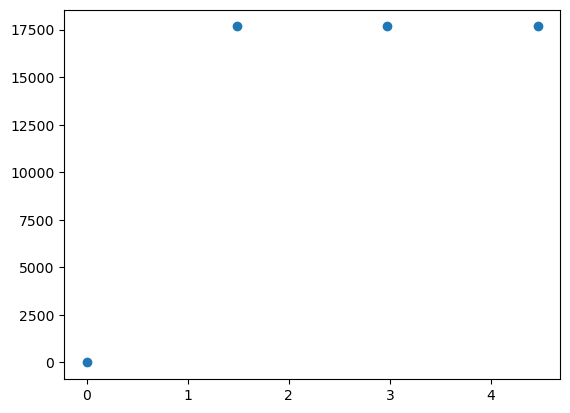

In [129]:
sample_bus = BusModel(a_prof)
vees = []
dists = []
powe = [0]
tee = [0]
v=0
d = 0
while (v < 11.176 - 11.176/10):
    p, t = sample_bus.accelerate_v4(14.985, .0981)
    v = sample_bus.velocity()
    vees.append(v)
    d+=14.985
    dists.append(d)
    print(p, t)
    
    
print("---")
dist = 0
while (dist < 40):
    p, t = sample_bus.maintain_v4(14.985, .0981)
    print(p, t)
    dist += 14.985
    v = sample_bus.velocity()
    dists.append(dist+d)
    vees.append(v)
    powe.append(p)
    tee.append(tee[-1]+t)
    
print("---")
while (v > 0.05):
    p, t = sample_bus.brake_v3(14.985, .8, .0981)
    v = sample_bus.velocity()
    vees.append(v)
    d+=14.985
    dists.append(d)
    print(p, t)

fig, ax = plt.subplots(1, 1)
ax.scatter(tee, powe)


In [130]:
import random
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import RouteMap as rm

class TripDynamics:
    def __init__(self, route_map, bus_model, bus_ridership, ridership_type='mean', seed=None):
        self._route_map = route_map
        self._bus_model = bus_model
        self._ridership_type = ridership_type
        self._rand_seed = seed
        if (self._ridership_type == 'mean'):
            self._ridership = bus_ridership
        elif (self._ridership_type == 'chance'):
            self._ridership = self.riders_from_chance(bus_ridership)
        self._route_data = self._route_map.get_gdf()
        self._route_data['riders'] = self.generate_rider_profile()
        self._route_data['bus_mass'] = self.generate_mass_profile()
        #Presently unused and innacurate
        self._route_data['f_grav'] = self._route_data['bus_mass'] * self._route_map.get_hill_accel()
        self._route_data['f_fric'] = self._route_data['bus_mass'] * self._route_map.get_fric_accel()  * self._bus_model.get_fric_coeff()
        
        self._trip_data = None
        
    
    def generate_rider_profile(self):
        '''
        generate_rider_profile generates a pandas series that contains the
        current amount of riders based on bus position
        
        Parameters:
        None
        
        Returns:
        pandas series matching length of route, with ridership numbers.
        Indicies identical to the route.
        '''
        
        # Copy the ridership changes as d_riders
        d_riders = self._ridership.copy()
        
        # get the series of stop booleans for the route
        stop_bools = self._route_data['is_stop'].copy()
        
        # create a new dataframe based on the stop booleans
        df = pd.DataFrame(stop_bools, columns=['is_stop'])
        
        # default change in riders is 0
        df['d_riders'] = 0
        
        # get a list of indexes on the route that are stops
        stop_indexes = list(df[df['is_stop']==True].index)
        
        # At the stops, add the change in riders
        df.iloc[stop_indexes, df.columns.get_loc('d_riders')] = d_riders
        
        # make the cumulative riders and return it
        df['riders'] = df['d_riders'].cumsum()
        
        # Assign a class variable for ridership change
        self._ridership_change = df['d_riders']
        
        return df['riders']
    
    

    def generate_mass_profile(self):
        '''
        generate_mass_profile generates a pandas series
        containing the total bus mass at each point along
        the trip, based on the ridership information of the route.
        
        Parameters:
        None
        
        Returns:
        a pandas series containing the total bus mass
        at each point on the route, indexed the same.
        '''
        
        # Copy the stops and riders
        stop_bools = self._route_data['is_stop'].copy()
        n_riders = self._route_data['riders'].copy()
        
        # Generate a new dataframe from the stop booleans
        df = pd.DataFrame(stop_bools, columns=['is_stop'])
        
        # Add the default bus mass to the dataframe
        df['total_mass'] = self._bus_model.get_mass()
        
        # add the ridership column to the dataframe
        df['n_riders'] = n_riders
        
        # get stop indexes
        stop_indexes = df[df['is_stop']==True].index
        
        # Get the column indexes of mass and riders
        mass_col_id = df.columns.get_loc('total_mass')
        rider_col_id = df.columns.get_loc('n_riders')
        
        # Loop through each stop,
        for i in range(len(stop_indexes)):
            
            # Get the current route point index
            cur_idx = stop_indexes[i]
            
            # get the ridership value for this index
            rider_val = df.iloc[cur_idx, rider_col_id]
            
            # Set the bus model's riders to the rider value
            self._bus_model.update_riders(rider_val, 'set')
            
            # Get the mass of the bus model
            df.iloc[cur_idx:, mass_col_id] = self._bus_model.get_mass()
        
        # return the total mass series
        return df['total_mass']

    
    def get_mass_profile(self):
        return self._route_data['bus_mass']
    

    def bus_trip(self):
        '''
        bus_trip uses the route data and bus information to simulate the bus
        travelling according to a set logic, and returns the route geodataframe with new information
        on acceleration, time, and velocity.
        '''
        
        # get the route geodataframe
        route = self._route_map.get_gdf()
        
        # Get get the stop boolean column, setting the final
        # two positions to stops to help ensure proper completion.
        #route['is_stop'][:-2] == True
        
        # get the frictional acceleration profile of the route
        fric_a_prof = self._route_map.get_fric_accel()
        
        # get the hill accelerational profile of the route
        hill_a_prof = self._route_map.get_hill_accel()
        
        # get the bus model
        bus = self._bus_model
        
        # get the friction coefficient of the bus model
        bus_f_coef = bus.get_fric_coeff()
        
        # get the maximum velocity for the defined bus
        max_v = bus.max_velocity()
        
        # variable for how hard the driver presses on the brake while braking
        braking_factor = 1
        
        # define new columns for velocity, stop distance, state, and stopping distance,
        # Power needed, and time change.
        route['vel.[m/s]'] = 0
        route['acc.[m/s^2]'] = 0
        route['stop_dist[m]'] = 0
        route['stppn_dist'] = 0
        route['power_needed[W]'] = 0
        route['st'] = 0
        route['time_change[s]'] = 0
        route['inertial_force'] = 0
        route['r_change'] = abs(self._ridership_change) > 0
        
        # Generate empty lists to hold the same values as above.
        vel_list = []
        acc_list = []
        dist_list = []
        stp_d_ls = []
        power = []
        st_ls = []
        dt_ls = []
        
        # get the accelerational profile of the bus.
        accel_profile = bus.get_accel_profile()
        
        random.seed(42)
        # Set up a boolean for checking if the bus will stop.
        is_stopping = (random.randrange(3) == 0)
        
        # Set up the final point of the route so that the bus actually stops there.
        route.at[len(route)-2,'is_stop'] = True
        route.at[len(route)-2, 'r_change'] = True
        
        # Loop through each point on the route
        for i in range(1, len(route)-1):
            
            # update the bus's mass.
            current_mass = self._route_data['bus_mass'][i]
            bus.update_mass(current_mass)
            
            # get the current point distance in meters
            point_dist = route['point_distances[km]'][i]*1000 # convert to meters
            
            # get the cumulative distance travelled to this point in meters
            cum_dist = route['cumulative_distance[km]'][i]*1000 # convert to meters
            
            # get the cumulative distance column id
            cum_dist_col_id = route.columns.get_loc('cumulative_distance[km]')
            
            # get the dataframe containing the remaining points that have not been visited
            remaining_trip = route.iloc[i:]
            
            # set the distance to the stop to a dummy variable of 0
            dist_to_stop = 0
            
            # set the index of the next stop to dummy variable of 0
            next_stop_index = 0
            
            # get the list of stops as defined by the distance between each stop on the route,
            #including signals, in meters
            stops_remain = remaining_trip[((remaining_trip['is_stop'] == True) & remaining_trip['r_change'] == True)| ((remaining_trip['is_signal'] == True) & is_stopping)]['cumulative_distance[km]'].reset_index(drop=True)*1000 #convert to meters

            # if there are remaining stops,
            if (len(stops_remain) != 0):
                
                # set the distance to the stop to be the difference between the stop distance
                # and cumulative distance
                dist_to_stop = stops_remain[0]-cum_dist # meters
                
                # set the next stop index, handle errors where for some reason there is no value for cumulative distance.
                next_stop_match = route['cumulative_distance[km]'][route['cumulative_distance[km]'] == stops_remain[0]/1000]
                if (len(next_stop_match) != 0):
                    next_stop_index = route['cumulative_distance[km]'][route['cumulative_distance[km]'] == stops_remain[0]/1000].index[0]
                else:
                    # if there's nothing, assume the next stop index is in the next 10.
                    next_stop_index = i+10
                
            # get the current velocity of the bus
            start_velocity = bus.velocity()  
            
            # get the acceleration of bus friction at the point
            a_fric = fric_a_prof[i]*bus_f_coef
            
            # get the acceleration due to gravity at the point
            a_hill = hill_a_prof[i]
            
            # combine the accelerations to get external (to the bus's motor) acceleration
            ext_a = a_fric - a_hill 
            
            # calculate the stopping distance based on the starting velocity and external acceleration
            stopping_dist = bus.get_braking_distance(start_velocity, braking_factor, ext_a) #meters
            
            # get the speed limit at current point
            point_sp_lim = route['speed_limit[km/s]'][i] * 1000 # meters
            
            # Error correction for when speed limit has noise
            stable_limit = True
            if (i > 2 and i < len(route)-2):
                # get a boolean for if any change in speed limit is stable:
                mean_limit = (route['speed_limit[km/s]'][i-1:i+1]*1000).mean()
                stable_limit = abs(point_sp_lim - mean_limit) < .1
                point_sp_lim = mean_limit
            
            # set up a variable for status
            status = ""
            d_power = 0
            d_t = 0
            
            # Driving logic: -------------------------------------------------------
            #If at rest, accelerate for the distance between this and the next point
            if (start_velocity < 0.1):
                status = "accel_from_0"
                d_power, d_t = bus.accelerate_v4(point_dist, ext_a)
                
            # If the distance difference between stopping distance and distance to the stop
            # is less than half the point distance resolution, then brake
            
            elif ((dist_to_stop < (stopping_dist + point_dist))): #and (abs(self._ridership_change[next_stop_index]) > 0)):
                status = "Stopping_brake"
                d_power, d_t = bus.brake_v3(point_dist, braking_factor, ext_a)
            #elif((dist_to_stop-stopping_dist)<= point_dist):
                
            # If the starting velocity is less than the speed limit, accelerate. Margin is 1/20th of speed limit.
            elif(start_velocity < (point_sp_lim - point_sp_lim/20)):
                status = "speed_lim_accel"
                d_power, d_t = bus.accelerate_v4(point_dist, ext_a)
                
            # if the starting celocity is greater than the speed limit, 
            elif(start_velocity > (point_sp_lim+point_sp_lim/20)):
                status = "speed_lim_brk"
                # find the distance needed to reach speed limit
                b_dist = ((point_sp_lim)**2 - start_velocity**2)/2 /(bus.get_b_accel())
                # brake for that distance
                d_power, d_t = bus.brake_v3(b_dist, braking_factor-.2, ext_a)
            else:
                status = "maintain_v"
                d_power, d_t = bus.maintain_v4(point_dist, ext_a)
            # End driving logic ---------------------------------------------------------
            
            
            # Append all the statuses and data to their lists
            st_ls.append(status)
            vel_list.append(bus.velocity())
            acc_list.append(bus.get_acceleration())
            dist_list.append(dist_to_stop)
            stp_d_ls.append(stopping_dist)
            power.append(d_power)
            dt_ls.append(d_t)
        
        # convert the lists and apply them to the respective columns
        route.iloc[1:-1, route.columns.get_loc('vel.[m/s]')] = vel_list
        route.iloc[1:-1, route.columns.get_loc('acc.[m/s^2]')] = acc_list
        route.iloc[1:-1, route.columns.get_loc('stop_dist[m]')] = dist_list
        route.iloc[1:-1, route.columns.get_loc('stppn_dist')] = stp_d_ls
        route.iloc[1:-1, route.columns.get_loc('power_needed[W]')] = power
        route.iloc[1:-1, route.columns.get_loc('st')] = st_ls
        route.iloc[1:-1, route.columns.get_loc('time_change[s]')] = dt_ls
        
        route['elapsed_time[s]'] = route['time_change[s]'].cumsum()
        
        # Set the route GDF to an instance variable, then return it.
        self._trip_data = route
        return route
    
    
    def get_all_data(self):
        '''
        get_all_data returns the dataframe generated after a trip is performed.
        Parameters:
        N/A
        Returns: 
        Dataframe of Trip data, or None if no trip has been performed.
        '''
        if (self._trip_data is None):
            print("Warning, bus_trip() method has not yet been used!")
        return self._trip_data
      
        
    def generate_ESS_profile(self):
        '''
        generate_ESS_profile() is a method to create the Energy Storage System
        power profile based on the required power. Note: This requires bus_trip()
        to be run prior.
        
        Parameters:
        N/A
        
        Returns:
        Pandas series containing required power from the ESS.
        '''
        # Get the trip data's power requirements
        power_profile = self.get_all_data()['power_needed[W]']
        
        # Apply the instance power method to the power profile.
        ESS_profile = power_profile.apply(self.calc_instance_power)
        
        # Return the profile.
        return ESS_profile
    
    
    def calc_instance_power(self, value):
        '''
        calc_instance_power takes in a power value,
        and converts it to the corresponding load on the ESS.
        
        Parameters:
        value: a power value in Watts, as an int or float.
        
        Returns:
        converted battery power as a float.
        '''
        # Get the bus model parameters.
        motor_eff = self._bus_model.get_motor_eff()
        invert_eff = self._bus_model.get_invert_eff()
        aux_eff = self._bus_model.get_auxill_efficiency()
        aux_load = self._bus_model.get_aux_load()
        regen_eff = self._bus_model.get_regen_eff()
        max_regen = -100000
        
        # set the battery power to zero.
        bat_pow = 0
        
        # Including Auxilliary load, though not strictly important at the moment. 
        if (value >= 0):
            # Discharging, converting the needed power into power battery must exert
            bat_pow = value/(motor_eff*invert_eff) + (aux_load/aux_eff)
        elif(value*regen_eff*motor_eff > max_regen):
            #charging, the regenerative braking ALL the time, max regen is 100
            bat_pow = value*regen_eff*motor_eff + (aux_load/aux_eff)
        else:
            bat_pow = max_regen + (aux_load/aux_eff)
            
            
        # Return the battery power.
        return bat_pow
    
    
    def export_trip_data(self):
        '''
        export_trip_data generates a geodataframe with the most relevant informaton for
        ease of use and understanding. For a hollistic report, get_all_data is better suited.
        
        Parameters:
        N/A
        
        Returns:
        geodataframe containing trip geometry, elevation, distance, grade, ridership, mass, velocity,
        elapsed time, and power needed in Watts. 
        '''
        # Drop non-relevant columns.
        raw_trip_data = self.get_all_data().copy()
        raw_trip_data.drop("stop_dist[m]", axis='columns', inplace=True)
        raw_trip_data.drop("stppn_dist", axis='columns', inplace=True)
        raw_trip_data.drop("power_needed[W]", axis='columns', inplace=True)
        raw_trip_data.drop("is_stop", axis='columns', inplace=True)
        raw_trip_data.drop("is_signal", axis='columns', inplace=True)
        raw_trip_data.drop("point_distances[km]", axis='columns', inplace=True)
        raw_trip_data.drop("latitude", axis='columns', inplace=True)
        raw_trip_data.drop("longitude", axis='columns', inplace=True)
        raw_trip_data.drop("speed_limit[km/s]", axis='columns', inplace=True)
        
        # Add the ESS profile.
        raw_trip_data['power_needed[W]'] = self.generate_ESS_profile()
        
        # return the trip data.
        return raw_trip_data

In [131]:
# Load the csv of the rider difference
# sorted_riders_diff = (pd.read_csv('rider_diff_22.csv', index_col=False, header=0))['0']
default_bus = BusModel(a_prof)
# generate a tripDynamics object, using the route map, bus, and ridership
# changes
pd.set_option('display.max_rows', None)
test_trip_dynamic = TripDynamics(smoothed_test_map,
                                    default_bus,
                                    sorted_riders_diff)

# Run the trip
test_trip = test_trip_dynamic.bus_trip()

In [133]:
#test_trip[(test_trip['cumulative_distance[km]']> 35) & (test_trip['cumulative_distance[km]']< 40)]
#test_trip[test_trip.index > 1590]

Total Energy Used: 87.11674666636297 kWh
Heuristic: 0.3465508119596857 mi/kwh


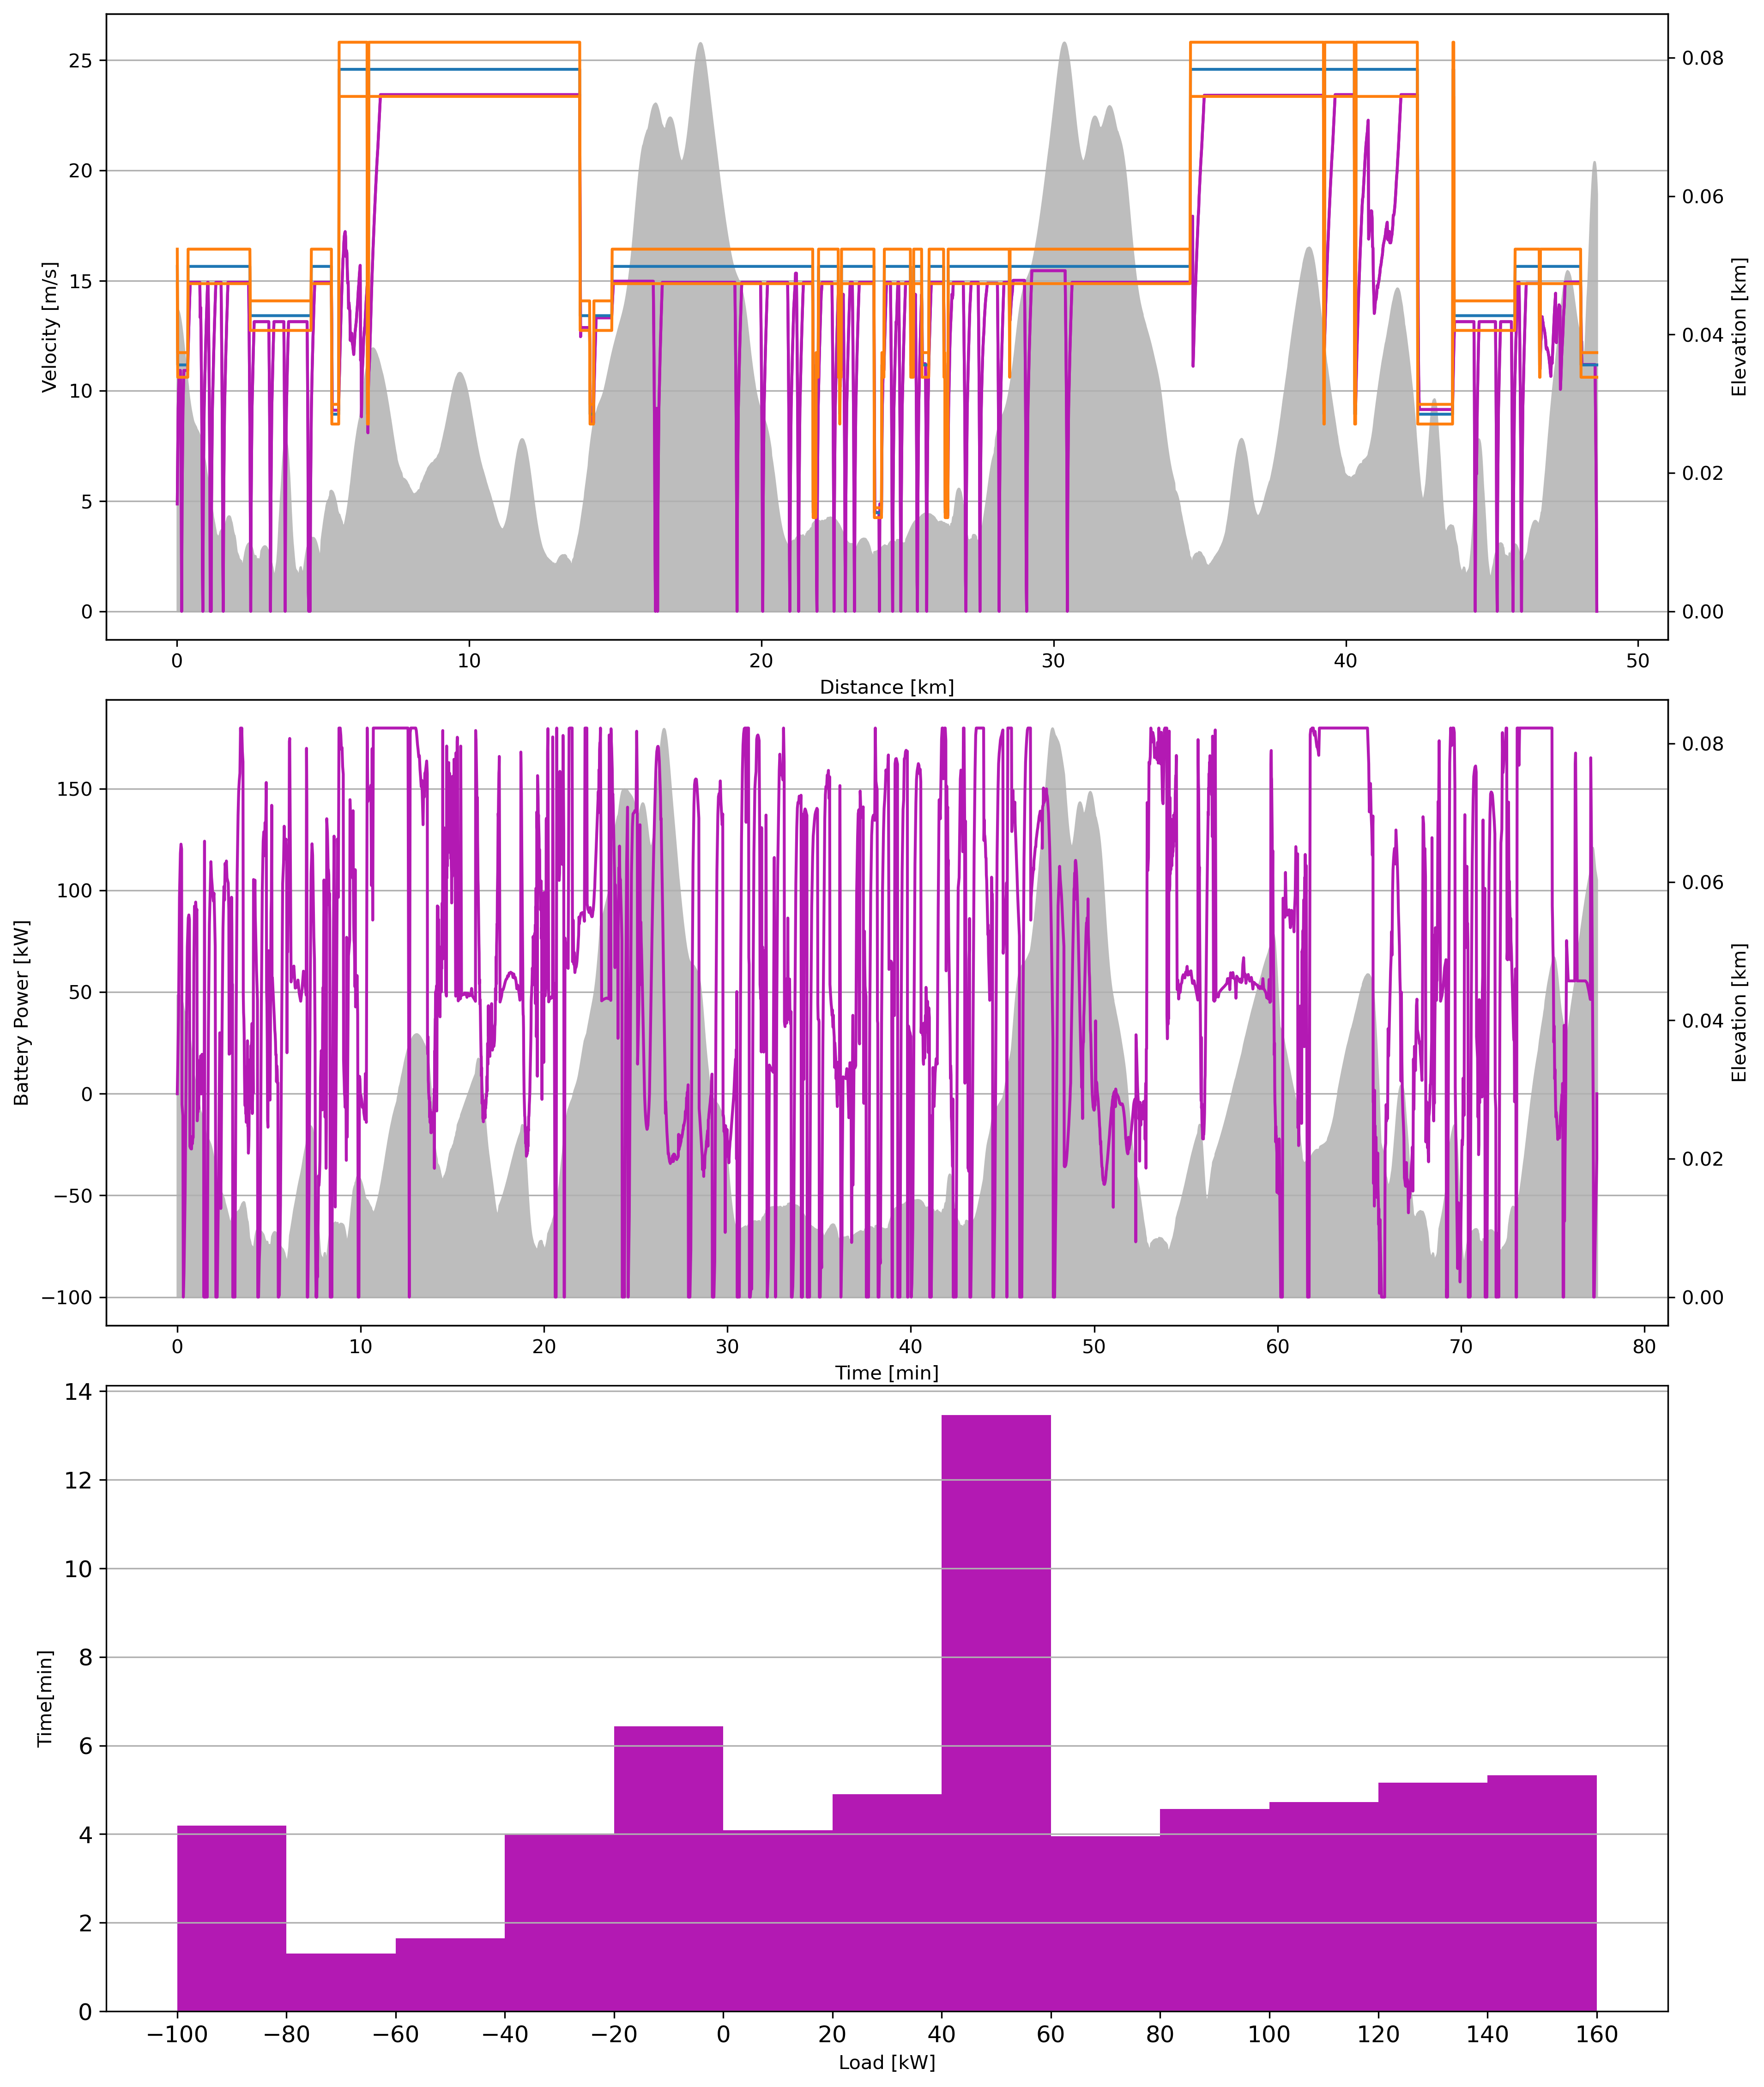

In [134]:
# plot the ESS load:
# get the ESS profile of the trip:
ess_prof = test_trip_dynamic.generate_ESS_profile()

# Convert the ess profile to kilowatts:
ess_prof = ess_prof/1000

raw_prof = test_trip['power_needed[W]']/1000

# get the distance series:
distance = test_trip['cumulative_distance[km]']

# get the elevation series:
elev = test_trip['elevation[km]']

# get the time change series:
delta_tees = test_trip['time_change[s]']

# get running time series
time = test_trip['elapsed_time[s]']

# convert time change to minutes
delta_tees = delta_tees/60
time = time/60

# generate figure
fig, ax = plt.subplots(3, 1, figsize = (12, 15), dpi=300)
plt.tight_layout()



# Load profile (distance based)
#ax[0].plot(distance, test_trip['vel.[m/s]']*2.236, c='#b319b3')
ax[0].plot(distance, test_trip["vel.[m/s]"], c='#b319b3')
#ax[0].plot(distance, ess_prof, c='#b319b3')
ax[0].set_xlabel("Distance [km]")
#ax[0].set_ylabel("Battery Power [kW]")
ax[0].set_ylabel("Velocity [m/s]")
ax[0].set_zorder(1)
ax[0].set_facecolor('none')
ax[0].grid(axis='y')
#ax[0].set_xlim(15.8, 16.4)
#ax[0].set_xlim(37.5,40)
#ax[0].set_xlim(23.68, 24)
#ax[0].set_xlim(7,8)
#ax[0].set_ylim(0, 15)
ax[0].plot(distance, test_trip["vel.[m/s]"], c='#b319b3')
ax[0].plot(distance, test_trip['speed_limit[km/s]']*1000)
ax[0].plot(distance, test_trip['speed_limit[km/s]']*1000 + test_trip['speed_limit[km/s]']*1000/20, c='tab:orange')
ax[0].plot(distance, test_trip['speed_limit[km/s]']*1000 - test_trip['speed_limit[km/s]']*1000/20, c='tab:orange')

# Elevation
ax_0_1 = ax[0].twinx()
ax_0_1.fill_between(distance, elev, color = '#BDBDBD')
ax_0_1.set_ylabel("Elevation [km]")
ax_0_1.set_zorder(0)

#ax_0_1.scatter(distance, test_trip['is_stop']*elev, c="tab:green")
#ax_0_1.scatter(distance, test_trip['is_signal']*elev, c="tab:red")

# Load profile (time based)
ax[1].plot(time, ess_prof, c='#b319b3')
ax[1].set_xlabel("Time [min]")
ax[1].set_ylabel("Battery Power [kW]")
ax[1].set_zorder(1)
ax[1].set_facecolor('none')
ax[1].grid(axis='y')

# Elevation
ax_1_1 = ax[1].twinx()
ax_1_1.fill_between(time, elev, color = '#BDBDBD')
ax_1_1.set_ylabel("Elevation [km]")
ax_1_1.set_zorder(0)


# Power Bin Histogram
bins = [-100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, 120, 140, 160]
ax[2].hist(ess_prof, color='#b319b3', bins=bins, weights=delta_tees)
ax[2].set_ylabel('Time[min]')
ax[2].set_xlabel('Load [kW]')
ax[2].tick_params(labelsize=12)
ax[2].set_xticks(bins)
ax[2].grid(axis='y')

# Create a column for the ess profile
dts = test_trip['time_change[s]']
net_energy = (ess_prof*dts).sum()/3600 # kWh
print("Total Energy Used: {} kWh".format(net_energy))
print("Heuristic: {} mi/kwh".format(list(test_trip['cumulative_distance[km]'])[-2]*0.6213712 / net_energy))
# control drag coefficient
# Control road drag
# plot each term, what value
# Elevation
# ffc of the parameters for the bus to deduce which is the issue
# reduce passenger mass/INCREASE mass

# Is there a straight line where this happens?
# is it wiggling in slope causing instability?
# look at linear stability theory

# different slopes, different enveopes of distance and uncertainty, plot stable, unstable and find stable and unstable
# damping factor via forward differencing, remove oscillation

# Standard EV on ld veh. 4mi p kwh
# gut check should be kwh/mi

# Elevation from google API?


In [17]:
test_trip[(test_trip['cumulative_distance[km]']>37.4) & (test_trip['cumulative_distance[km]']<38.5)]

,Unnamed: 0,geometry,elevation[km],latitude,longitude,point_distances[km],cumulative_distance[km],speed_limit[km/s],is_stop,is_signal,vel.[m/s],acc.[m/s^2],stop_dist[m],stppn_dist,power_needed[W],st,time_change[s],inertial_force,r_change,elapsed_time[s]
2531,2531,POINT (-122.29281 47.52842),0.018833,-122.292806,47.528424,0.014657,37.401784,0.024587,False,False,24.206224,0.00,7040.174971,163.28330,108612.801176,maintain_v,0.605485,0,False,2976.794901
2532,2532,POINT (-122.29286 47.52856),0.018959,-122.292863,47.528559,0.014657,37.416440,0.024587,False,False,24.206224,0.00,7025.518208,162.64296,111220.311820,maintain_v,0.605496,0,False,2977.400397
2533,2533,POINT (-122.29292 47.52869),0.019242,-122.292920,47.528693,0.014659,37.431099,0.024587,False,False,24.206224,0.00,7010.859094,153.69949,149909.622971,maintain_v,0.605593,0,False,2978.005990
2534,2534,POINT (-122.29298 47.52883),0.019511,-122.292977,47.528828,0.014659,37.445758,0.024587,False,False,24.206224,0.00,6996.200084,154.47135,146393.934205,maintain_v,0.605588,0,False,2978.611578
2535,2535,POINT (-122.29303 47.52896),0.019822,-122.293034,47.528963,0.014660,37.460418,0.024587,False,False,24.206224,0.00,6981.540086,152.23153,156694.317776,maintain_v,0.605629,0,False,2979.217208
2536,2536,POINT (-122.29309 47.52910),0.020126,-122.293091,47.529097,0.014660,37.475078,0.024587,False,False,24.206224,0.00,6966.880061,152.57869,155077.998774,maintain_v,0.605630,0,False,2979.822838
2537,2537,POINT (-122.29315 47.52923),0.020436,-122.293148,47.529232,0.014660,37.489739,0.024587,False,False,24.206224,0.00,6952.219739,152.24065,156651.750724,maintain_v,0.605643,0,False,2980.428481
2538,2538,POINT (-122.29321 47.52937),0.020729,-122.293207,47.529366,0.014663,37.504402,0.024587,False,False,24.206224,0.00,6937.556255,153.14618,152451.641572,maintain_v,0.605773,0,False,2981.034254
2539,2539,POINT (-122.29327 47.52950),0.021059,-122.293268,47.529498,0.014670,37.519073,0.024587,False,False,24.236508,0.05,6922.885934,151.21941,143082.292675,maintain_v,0.605677,0,False,2981.639931
2540,2540,POINT (-122.29333 47.52963),0.021395,-122.293329,47.529631,0.014671,37.533743,0.024587,False,False,24.236508,0.00,6908.215305,155.66821,142929.307916,maintain_v,0.605311,0,False,2982.245242


mean load: -687.5525028992282
    stdev: 492.00498978271276


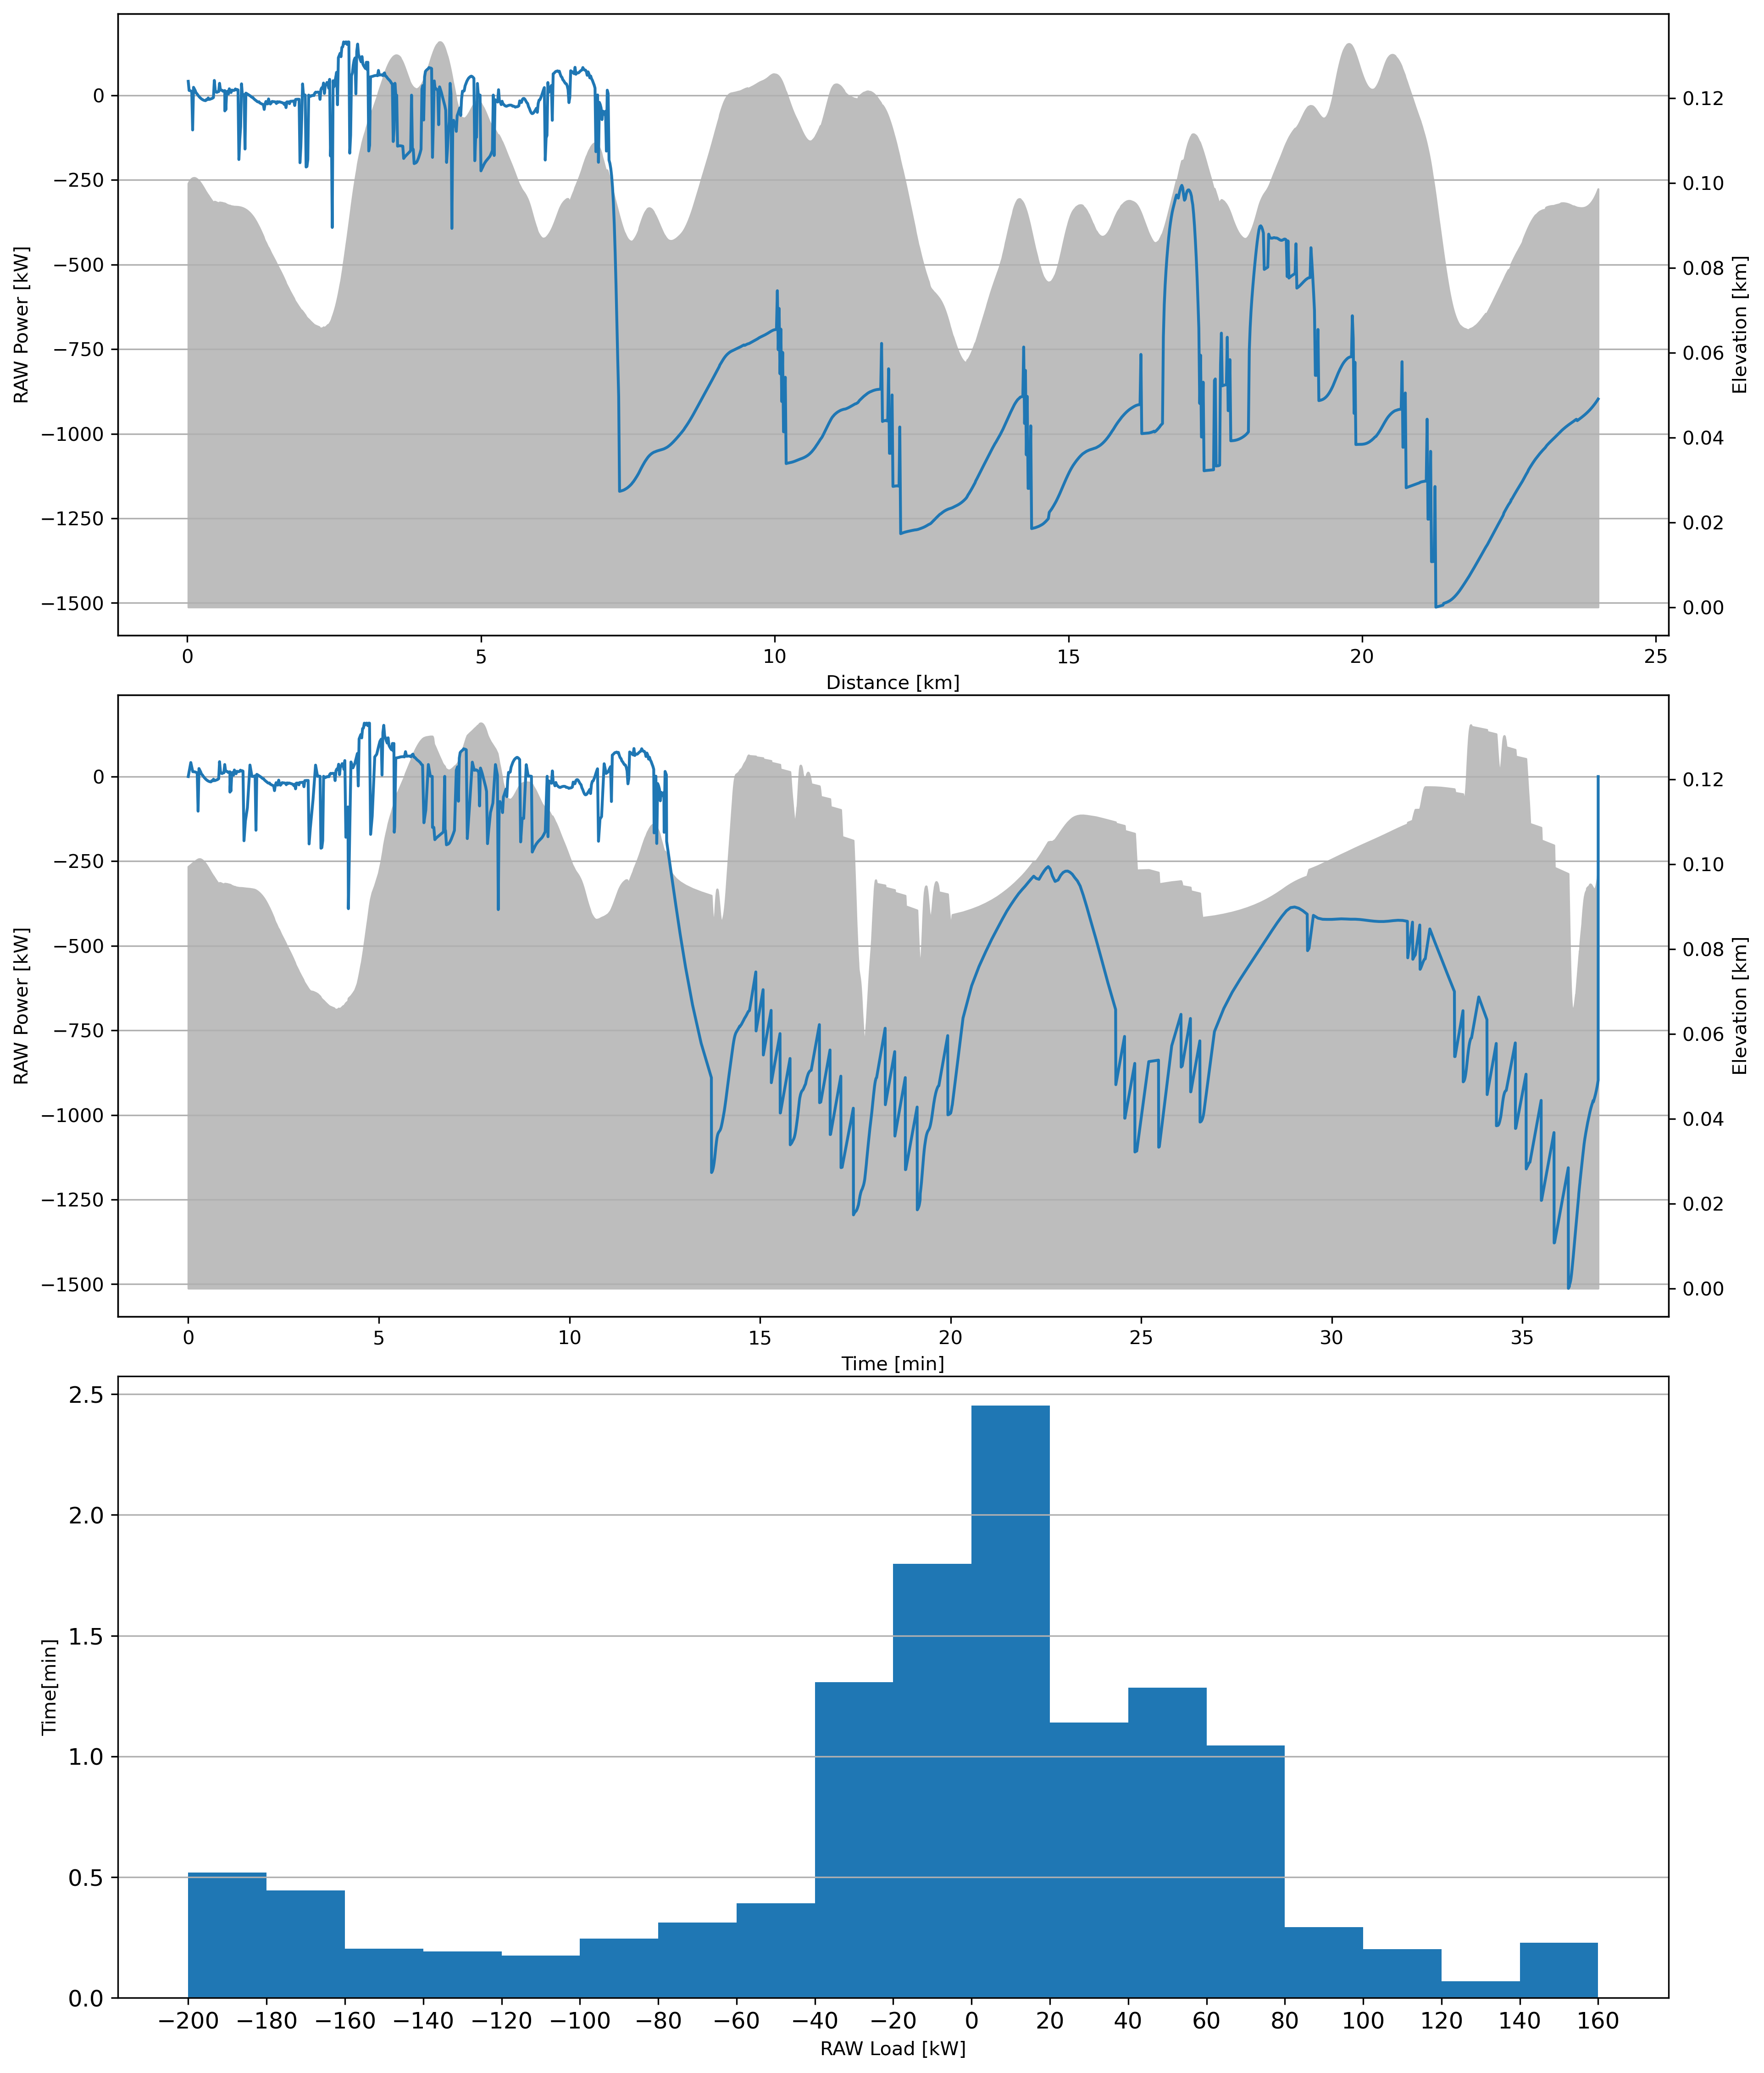

In [611]:
# Plot the raw load

# Time in hours * each bin BC we want to know kwH, 
# generate figure
fig, ax = plt.subplots(3, 1, figsize = (12, 15), dpi=300)
plt.tight_layout()

# Load profile (distance based)
ax[0].plot(distance, raw_prof, c='tab:blue')
ax[0].set_xlabel("Distance [km]")
ax[0].set_ylabel("RAW Power [kW]")
ax[0].set_zorder(1)
ax[0].set_facecolor('none')
ax[0].grid(axis='y')


# Elevation
ax_0_1 = ax[0].twinx()
ax_0_1.fill_between(distance, elev, color = '#BDBDBD')
ax_0_1.set_ylabel("Elevation [km]")
ax_0_1.set_zorder(0)

# Load profile (time based)
ax[1].plot(time, raw_prof, c='tab:blue')
ax[1].set_xlabel("Time [min]")
ax[1].set_ylabel("RAW Power [kW]")
ax[1].set_zorder(1)
ax[1].set_facecolor('none')
ax[1].grid(axis='y')

# Elevation
ax_1_1 = ax[1].twinx()
ax_1_1.fill_between(time, elev, color = '#BDBDBD')
ax_1_1.set_ylabel("Elevation [km]")
ax_1_1.set_zorder(0)


# Power Bin Histogram
bins = [-200,-180,-160,-140,-120,-100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, 120, 140, 160]
ax[2].hist(raw_prof, color='tab:blue', bins=bins, weights=delta_tees)
ax[2].set_ylabel('Time[min]')
ax[2].set_xlabel('RAW Load [kW]')
ax[2].tick_params(labelsize=12)
ax[2].set_xticks(bins)
ax[2].grid(axis='y')

print('mean load: {}'.format(raw_prof.mean()))
print('    stdev: {}'.format(raw_prof.std()))